In [1]:
import math
import numpy as np
from Value import Value
from MLP import *
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
%matplotlib inline

In [19]:
# loading dataset
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)
X = X / 255.0 # normalize pixels
y = y.astype(int)

In [20]:
# splitting data
np.random.seed(42)
indices = np.random.permutation(len(X))
split = int(0.8 * len(X))
train_idx, test_idx = indices[:split], indices[split:]
X_train, X_test, y_train, y_test = X[train_idx], X[test_idx], y[train_idx], y[test_idx]

np.shape(X_train)

(56000, 784)

In [4]:
# ie. 4 = [0,0,0,0,1,0,0,0,0,0]
def encode_labels(y):
    one_hot = np.zeros((len(y), 10))
    one_hot[np.arange(len(y)), y] = 1
    return one_hot
y_train_encoded = encode_labels(y_train)
y_test_encoded = encode_labels(y_test)

In [5]:
# Model that will be used
model = MLP(196, [64, 32, 10])

In [6]:
# using different loss function
def softmax(logits):
    exps = [x.exp() for x in logits]
    sum_exps = sum(exps, Value(0))
    probs = [e / sum_exps for e in exps]
    return probs

def cross_entropy_loss(logits, true_label):
    probs = softmax(logits)
    loss = Value(0)
    for p, t in zip(probs, true_label):
        if t == 1:
            loss -= p.log()
    return loss

In [7]:
def update_weights(model, base_lr, e, decay=0.96):
    lr = base_lr * (decay ** e)
    for p in model.parameters():
         p.data += -lr * p.grad

In [ ]:
from PIL import Image
import numpy as np

def resize_dataset(X, new_size=(14,14)):
    resized_images = []
    for img_array in X:
        img = Image.fromarray(img_array)
        img_small = img.resize(new_size, Image.Resampling.LANCZOS)
        resized_images.append(np.array(img_small)) 
    return np.array(resized_images)

In [11]:
# the training begins
X_train = resize_dataset(X_train, (14, 14))
X_test = resize_dataset(X_test, (14, 14))
X_train = X_train[:1000]
y_train_encoded = y_train_encoded[:1000]
epochs = 40
for epoch in range(25, epochs):
    
    total_loss = 0
    for x, y_true in zip(X_train, y_train_encoded):
        # forward pass
        x_val = [Value(xi) for xi in np.ravel(x)]
        y_pred = model(x_val)
        loss = cross_entropy_loss(y_pred, y_true)

        # zero gradients
        model.zero_grad()

        # backward pass
        loss.backward()

        # update weights
        update_weights(model, base_lr=0.2, e=epoch)
        total_loss += loss.data

    print(f"Epoch: {epoch + 1}, Loss: {total_loss / len((X_train))}")

Epoch: 26, Loss: 1.3524259108072207
Epoch: 27, Loss: 1.340797374785405
Epoch: 28, Loss: 1.3262896825932062
Epoch: 29, Loss: 1.3036682211355057
Epoch: 30, Loss: 1.2853805441742288
Epoch: 31, Loss: 1.2613890733299704
Epoch: 32, Loss: 1.2800803802391847
Epoch: 33, Loss: 1.2548047463885272
Epoch: 34, Loss: 1.2377037367228227
Epoch: 35, Loss: 1.246479296332746
Epoch: 36, Loss: 1.2069004677443043
Epoch: 37, Loss: 1.180867781070629
Epoch: 38, Loss: 1.1941594524635193
Epoch: 39, Loss: 1.1883555695244263
Epoch: 40, Loss: 1.1519569070785027


In [15]:
correct = 0
total = len(X_test[:1000])

for x, y_true in zip(X_test[:1000], y_test[:1000]):
    x_vals = [Value(xi) for xi in np.ravel(x)]
    y_pred = model(x_vals)
    pred_label = np.argmax([p.data for p in y_pred])
    
    if pred_label == y_true:
        correct += 1

accuracy = correct / total
print(f"Test accuracy: {accuracy * 100:.2f}%")

Test accuracy: 71.00%


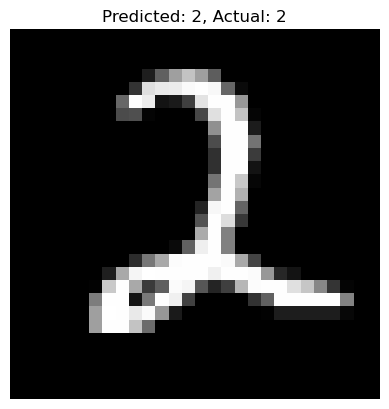

In [39]:
import matplotlib.pyplot as plt
import numpy as np

i = 9
img = X_test[i]
label = y_test[i]

# Predict
x_vals = [Value(xi) for xi in np.ravel(img)]
y_pred = model(x_vals)
pred_label = np.argmax([p.data for p in y_pred])


plt.imshow(img.reshape(28, 28), cmap='gray')  
plt.title(f"Predicted: {pred_label}, Actual: {label}")
plt.axis('off')
plt.show()

In [41]:
import pickle
import os
os.makedirs("models", exist_ok=True)

params = [p.data for p in model.parameters()]
with open("models/micrograd_model.pkl", "wb") as f:
    pickle.dump(params, f)
print("Model saved")

Model saved


# How to load micrograd_model

```python
import os
import pickle

# Load saved parameter values (list of floats)
with open("models/micrograd_model.pkl", "rb") as f:
    saved_params = pickle.load(f)

for p in zip(model.parameters(), saved_params):
    p.data = val